Neuroevolution: Exercise 5
=========
###### Artur Ganzha 10019651
---------	
###### Raul Gorek 10061333
---------	

In [21]:
import gymnasium as gym
import numpy as np
from collections import namedtuple, deque
import random

In [22]:
### NeuralNet
def derivative_bcel(prediction, ground_truth):
    x =  np.where(ground_truth == 0, 1.0 / (1.0 - prediction), -1.0 / prediction)
    return x

def derivative_mse(prediction, ground_truth):
    batch_size = ground_truth.shape[0]
    return -2 * (ground_truth - prediction) / batch_size

class Linear:
    def __init__(self, input_size, output_size):
        self.input_size = input_size
        self.output_size = output_size
        self.W = np.random.uniform(-1, 1,(self.input_size,self.output_size))
        self.B = np.zeros((1, self.output_size))
    
    def forward(self, x):
        self.fw = x
        return np.dot(x, self.W) + self.B
    
    def backward(self, d, lr):
        d_w = np.dot(self.fw.T, d)
        d_e = np.dot(d, self.W.T)
        d_b = np.sum(d, axis=0, keepdims=True)
        self.W -= lr * d_w / self.fw.shape[0]
        self.B -= lr * d_b / self.fw.shape[0]
        return d_e


class ReLU:
    def __init__(self):
        pass

    def forward(self, x):
        self.fw = x
        return x * (x > 0)
    
    def backward(self, d, lr):
        return d * np.where(self.fw > 0, 1.0, 0.0)
    

class Sigmoid:
    def __init__(self):
        pass
    
    def forward(self, x):
        self.fw = x
        self.out = 1.0 / (1.0 + np.exp(-x))
        return self.out
    
    def backward(self, d, lr):
        return d * (self.out * (1.0 - self.out))
    

class NeuralNetwork:
    def __init__(self, layers: list):
        self.layers = layers

    def forward_pass(self, x):
        for layer in self.layers:
            x = layer.forward(x)
        return x
    
    def backward_pass(self, deriv, lr):
        for layer in reversed(self.layers):
            deriv = layer.backward(deriv, lr)



# Aufgabe 1

In [23]:
env = gym.make('CartPole-v1')
num_actions = env.action_space.n
obs_shape = env.observation_space.shape[0]

q_net = NeuralNetwork([
    Linear(obs_shape, 32), ReLU(),
    Linear(32, 32), ReLU(),
    Linear(32, num_actions)
])

state, info = env.reset()
action = env.action_space.sample()
next_state, reward, terminated, truncated, _ = env.step(action)
done = terminated or truncated

q_values = q_net.forward_pass(state)
print(q_values)

[[ 0.17852823 -0.01534559]]


# Aufgabe 2

In [24]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward', 'done'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

# Aufgabe 3

In [25]:
GAMMA = 0.95
q_target = q_net.forward_pass(state)
q_target[0, action] = reward + GAMMA * np.max(q_net.forward_pass(next_state)) * (1-done)
print(q_target)

[[0.17852823 1.20527208]]


In [26]:
q_values - q_target

array([[ 0.        , -1.22061767]])

In [27]:
def optimize():
    if len(buffer) < BATCH_SIZE:
        return
    transitions = buffer.sample(BATCH_SIZE)
    states = np.array([t[0] for t in transitions])
    actions = np.array([t[1] for t in transitions])
    rewards = np.array([t[2] for t in transitions])
    next_states = np.array([t[3] for t in transitions])
    dones = np.array([t[4] for t in transitions])
    Q_next_states = q_net.forward_pass(next_states)
    Q_now = q_net.forward_pass(states)
    Q_target = Q_now.copy()
    Q_target[np.arange(BATCH_SIZE), actions] = rewards + GAMMA * np.max(Q_next_states, axis=1) * (1-dones)
    grad = derivative_mse(ground_truth=Q_target, prediction=Q_now)
    grad = np.clip(grad, -2, 2)
    # print(grad)
    q_net.backward_pass(grad, LEARNING_RATE)

In [46]:
from IPython.display import clear_output
EPSILON = 1.0
EPSILON_DECAY = 0.997
MIN_EPSILON = 0.01
CONV_CRIT = 350
BATCH_SIZE = 4
LEARNING_RATE = 0.001

env = gym.make('CartPole-v1')
num_actions = env.action_space.n
obs_shape = env.observation_space.shape[0]
q_net = NeuralNetwork([
    Linear(obs_shape, 32), ReLU(),
    Linear(32, 32), ReLU(),
    Linear(32, num_actions)
])
buffer = ReplayMemory(100_000)


In [47]:
rewards = []
converged = False
episode = 1
while not converged:
    state, _ = env.reset()
    done = False
    steps = 0
    while not done:
        r = np.random.random()
        if r < EPSILON:
            action = env.action_space.sample()
        else:
            action = np.argmax(q_net.forward_pass(state))
        next_state, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated
        buffer.push(state, action, reward, next_state, done)
        state = next_state
        brk = optimize()
        steps += reward
        if np.mean(rewards[-2:]) > CONV_CRIT:
            converged = True
            break
    episode += 1
    EPSILON = max(MIN_EPSILON, EPSILON * EPSILON_DECAY)
    if episode % 50 == 0:
        print('Episode: ', episode, 'Reward: ', steps, 'Epsilon: ', EPSILON)
    rewards.append(steps)

Episode:  50 Reward:  16.0 Epsilon:  0.8631032605924442
Episode:  100 Reward:  22.0 Epsilon:  0.7427123967299725
Episode:  150 Reward:  86.0 Epsilon:  0.6391143788261682
Episode:  200 Reward:  56.0 Epsilon:  0.549966839143611
Episode:  250 Reward:  64.0 Epsilon:  0.4732541375663234
Episode:  300 Reward:  151.0 Epsilon:  0.40724178765469166
Episode:  350 Reward:  257.0 Epsilon:  0.3504372396299372
Episode:  400 Reward:  139.0 Epsilon:  0.3015561335851415


Text(0, 0.5, 'Return')

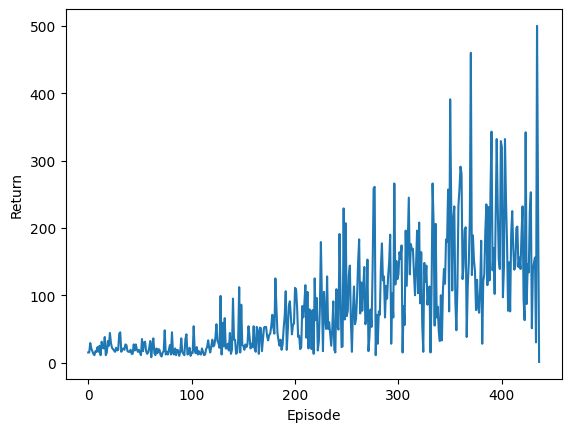

In [48]:
import matplotlib.pyplot as plt

plt.plot(np.arange(len(rewards)), rewards)
plt.xlabel('Episode')
plt.ylabel('Return')

In [50]:
env = gym.make('CartPole-v1', render_mode='human')
state, _ = env.reset()
done = False
while not done:
    env.render()
    action = np.argmax(q_net.forward_pass(state))
    state, reward, term, trunc, _ = env.step(action)
    done = term or trunc

env.close()